# Canadian Parliament data

In this notebook, we experiment the back-door adjustment on the data from the 36th and 39th parliament from [Hirst et al.](ftp://learning.cs.toronto.edu/dist/gh/Hirst-etal-2010-JADT.pdf) as well as on the data scrapped from the 40th parliament. We focus on building a robust classifier using the backdoor adjustment method.

For more details concerning the different parliaments, see the [List of Canadian federal parliaments](http://en.wikipedia.org/wiki/List_of_Canadian_federal_parliaments).

# Table of Contents

1. [Python imports][1]
2. [Load data from disk][2]
  1. [Download data from Dropbox][3]
  2. [Load files from disk (functions)][4]
  3. [Load data from disk (call to functions)][5]
  4. [Vectorize dataset][6]
3. [Experiments][7]
  1. [Load Classifier Models][8]
  2. [Fit on a parliament, predict on another one][9]
  3. [Back-door Adjustment Experiment][10]
  4. [Common top features][11]
[1]: #Python-imports
[2]: #Load-data-from-disk
[3]: #Download-data-from-Dropbox
[4]: #Load-files-from-disk-(functions)
[5]: #Load-data-from-disk-(call-to-functions)
[6]: #Vectorize-dataset
[7]: #Experiments
[8]: #Load-Classifier-Models
[9]: #Fit-on-a-parliament,-predict-on-another-one
[10]: #Back-door-Adjustment-Experiment
[11]: #Common-top-features

## Python imports

In [9]:
import glob
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
import os.path

from collections import defaultdict
from bs4 import BeautifulSoup
from scipy import sparse
from scipy.stats import pearsonr, sem
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
%matplotlib inline

## Load data from disk

### Download data from Dropbox
Our data is [stored on Dropbox](https://www.dropbox.com/sh/pcg731664f8h4fy/AAASxoqAM29Xglt7NMQdN9i9a/hansard.tgz?dl=1) and its access is protected by a password. If you are interested in using the data for research purposes, please email one of the author to obtain the password. Once you have downloaded and unpacked the data, set the following `DATAPATH` variable to the path where the data is stored.

In [11]:
# set path to the data
DATAPATH = 'C:\\Users\\vland\\Downloads'
HANSARD_PATH = os.path.join(DATAPATH, 'hansard')

### Load files from disk (functions)

In [15]:
def lazy_file_load(dir_path, file_regex, n=None, encoding='utf-8'):
    file_path_list = sorted(glob.glob(dir_path + file_regex))
    l = len(file_path_list)
    _n = l if n == None or n > l else n
    num = 0
    while num < _n:
        with open(file_path_list[num], encoding=encoding) as fd:
            c = fd.read()
            yield c
            num += 1
            
party_translation = {
    'Ref':'Conservative', 'PC':'Conservative', 'CPC':'Conservative',
    'Lib': 'Liberal'
}

def hansard_txt(dir_path='./', lang='e', n=None, ignore_alt_parties=True):
    regex_speaker = re.compile(r'(Mr\.|Mrs\.|Ms\.|Hon\.|The)([^\(:]*)(\((.+),(.+)\))?:$')
    regex_topic = re.compile(r'^([A-Z]{2,} +)+$')
    regex_comment = re.compile(r'^\([^\(]{4,}\)')

    name2party = defaultdict(set)
    party2names = defaultdict(set)
    content = defaultdict(list)

    topics = []
    for i, h in enumerate(lazy_file_load(dir_path, '/*'+lang, n, "ISO-8859-1")):
        h = h.split('HOUSE OF COMMONS')[1] # remove header
        lines = h.split('\n') # split on linefeed
        match_comment_idx = set([i for i, l in enumerate(lines) if regex_comment.match(l)])
        match_topic_idx = set([i for i, l in enumerate(lines) if regex_topic.match(l)])
        # remove comments, topics, and topic separations characters
        cond_del = lambda i: i in match_comment_idx or i in match_topic_idx or lines[i].strip() == '* * *'
        new_lines = [l for i,l in enumerate(lines) if not cond_del(i)]
        lines = new_lines
        match_speaker_tuples = [(i, regex_speaker.match(l)) for i, l in enumerate(lines) if regex_speaker.match(l)]
        for j, m in enumerate(match_speaker_tuples):
            prefix = m[1].group(1).strip()
            name = m[1].group(2).strip()
            n = ' '.join([prefix, name])
            if j+1 < len(match_speaker_tuples): # there is a next element
                next_m = match_speaker_tuples[j+1]
                content[n].extend(lines[m[0]+1:next_m[0]])
            else:
                content[n].extend(lines[m[0]+1:])
            if m[1].group(5) is not None:
                p = m[1].group(5).strip().strip('.')
                p = party_translation.get(p, 'Ignore')
                if not ignore_alt_parties or p != 'Ignore':
                    party2names[p].add(n)
                    name2party[n].add(p)
                else:
                    del content[n]
    return name2party, party2names, content        
    
def hansard_xml(dir_path, n=None,  ignore_alt_parties=True):
    regex_speaker = re.compile(r'(Mr\.|Mrs\.|Ms\.|Hon\.)([^\(]+)\((.+),(.+)\)')
    
    name2party = defaultdict(set)
    party2names = defaultdict(set)
    content = defaultdict(list)
    
    for i, h in enumerate(lazy_file_load(dir_path, '/*', n)):
        soup = BeautifulSoup(h, "lxml")
        interventions = soup.find_all('intervention', type='Debate')
        for intervention in interventions:
            title = intervention.personspeaking.affiliation.string
            if title:
                m = regex_speaker.match(title)
                if m:
                    prefix = m.group(1).strip()
                    name = m.group(2).strip()
                    n = ' '.join([prefix, name])
                    p = m.group(4).strip().strip('.')
                    p = party_translation.get(p, 'Ignore')
                    c = [p.get_text().strip() for p in intervention.content('paratext')]
                    if not ignore_alt_parties or p != 'Ignore':
                        name2party[n].add(p)
                        party2names[p].add(n)
                        content[n].extend(c)
    # remove politicians with ambiguous labels
    ambiguous_politicians = [k for k, v in name2party.items() if len(v) > 1]
    for pol in ambiguous_politicians:
        del name2party[pol]
        for _, names in party2names.items():
            names.discard(pol)
        del content[pol]
    return name2party, party2names, content

def parliament_stats(n2p, p2n):
    print('%d politicians, %d political parties.' % (len(n2p), len(p2n)))
    parties = sorted(list(p2n.keys()))
    for p in parties:
        print("- %s:\t%d politicians" % (p, len(p2n[p])))

### Load data from disk (call to functions)

In [17]:
n2p = {}
p2n = {}
content = {}
n2p[36], p2n[36], content[36] = hansard_txt(os.path.join(HANSARD_PATH, '36'))
n2p[39], p2n[39], content[39] = hansard_xml(os.path.join(HANSARD_PATH, '39'))
n2p[40], p2n[40], content[40] = hansard_xml(os.path.join(HANSARD_PATH, '40'))

In [18]:
parl_nums = [36,39,40]
for pn in parl_nums:
    print('= Parliament %d:' % pn)
    print('================')
    parliament_stats(n2p[pn], p2n[pn])

= Parliament 36:
257 politicians, 2 political parties.
- Conservative:	80 politicians
- Liberal:	177 politicians
= Parliament 39:
239 politicians, 2 political parties.
- Conservative:	135 politicians
- Liberal:	104 politicians
= Parliament 40:
237 politicians, 2 political parties.
- Conservative:	158 politicians
- Liberal:	79 politicians


### Vectorize dataset

In [5]:
def vectorize_speeches(p2n, content, pns=[36,39,40], parties=['Liberal', 'Conservative']):
    vec = TfidfVectorizer(min_df=15, max_df=.8, stop_words='english', max_features=500)
    
    le = preprocessing.LabelEncoder()
    le.fit(parties)
    
    governing = {
        36: 'Liberal',
        39: 'Conservative',
        40: 'Conservative'
    }
    
    def get_all_speeches():
        for pn in pns:
            for party in parties:
                for n in p2n[pn][party]:
                    yield ' '.join(content[pn][n])
                    
    def get_labels():
        all_Y = []
        all_C = []
        indices = {}
        idx = 0
        for pn in pns:
            indices[pn] = [idx]
            for party in parties:
                l = len(p2n[pn][party])
                idx += l
                all_Y.extend(le.transform([party]*l))
                c = 1 if party == governing[pn] else 0
                all_C.extend([c]*l)
            indices[pn].append(idx)
        return np.array(all_Y), np.array(all_C), indices
    
    all_X = vec.fit_transform(get_all_speeches())
    all_Y, all_C, indices = get_labels()

    X = {}
    Y = {}
    C = {}
    
    for pn, (start, end) in indices.items():
        X[pn] = all_X[start:end]
        Y[pn] = all_Y[start:end]
        C[pn] = all_C[start:end]
    return X, Y, C, np.array(vec.get_feature_names())

In [6]:
X, Y, C, feature_names = vectorize_speeches(p2n, content)

## Experiments

### Load Classifier Models

In [39]:
%run models.py
%run ba_c_study.py
backdoor_adjustment_Z5 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,5)
backdoor_adjustment_Z10 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,10)
backdoor_adjustment_Z100 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,100)
backdoor_adjustment_Z1000 = lambda x,y,z,t,u: backdoor_adjustment_var_C(x,y,z,t,u,1000)

### Fit on a parliament, predict on another one

In this experiment, we consider three different Canadian parliaments:

   - the 36th where the government is liberal and the opposition is conservative;
   - the 39th and 40th where the governments are conservative and the oppositions are liberal.

We show that when the governing party and the opposition party are swapped between the training and the testing data, then we have a substantial decrease in the prediction accuracy.

In [8]:
def fit_pred(clf_model, X, Y, C, p_fit, p_pred):
    # fit on p_fit
    clf = clf_model(X[p_fit], Y[p_fit], C[p_fit], None, None)
    # predict on p_pred
    Y_pred = clf.predict(X[p_pred])
    # compute baseline
    counts = [np.sum(1-Y[p_pred]), np.sum(Y[p_pred])]
    max_idx = np.argmax(counts)
    baseline = 1.*counts[max_idx]/np.sum(counts)
    # compute metrics
    acc = metrics.accuracy_score(Y[p_pred], Y_pred)
    return baseline, acc
#     print("\t- baseline = %.4f\n\t- acc = %.4f\n\t- f1 = %.4f" % (baseline, acc, f1))

In [9]:
def plot_matrix(mat, title, labels_x=None, labels_y=None, vmin=None, vmax=None, figsize=None, xlabel='Predict', ylabel='Fit'):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(mat, vmin=vmin, vmax=vmax)
    plt.title(title)
    fig.colorbar(cax)
    if labels_x:
        ax.set_xticks(np.arange(len(labels_x)))
        ax.set_xticklabels(labels_x)
    if labels_y:
        ax.set_yticks(np.arange(len(labels_y)))
        ax.set_yticklabels(labels_y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for y in range(mat.shape[0]):
        for x in range(mat.shape[1]):
            if mat[y,x] != 0:
                plt.text(x, y, '%.4f' % mat[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',
                         fontweight='bold')
    plt.show()
    

def cross_parliement_accuracy(clf_model, X, Y, C, parl_number=None):
    if parl_number is None:
        parl_number = [36,39,40]
    accuracy_matrix = np.ones((len(parl_number), len(parl_number)))
    baseline_matrix = np.ones((len(parl_number), len(parl_number)))

    for i, p_fit in enumerate(parl_number):
        for j, p_pred in enumerate(parl_number):
            base, acc = fit_pred(clf_model, X, Y, C, p_fit, p_pred)
            accuracy_matrix[i,j] = acc
            baseline_matrix[i,j] = base

    return accuracy_matrix


LR - avg accuracy = 0.687


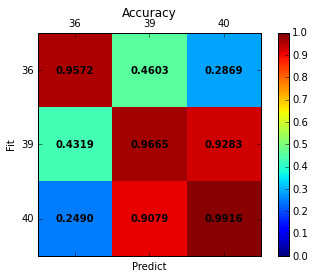

BA - avg accuracy = 0.505


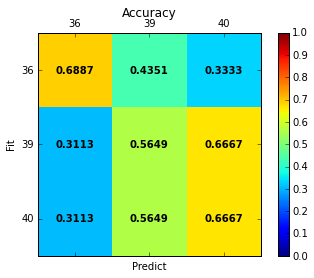

BAZ10 - avg accuracy = 0.505


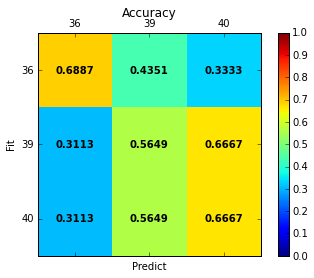

In [12]:
models = [('LR', lr), ('BA', backdoor_adjustment), ('BAZ10', backdoor_adjustment_Z10)]
for name, model in models:
    accuracy_matrix = cross_parliement_accuracy(model, X, Y, C)
    print("%s - avg accuracy = %.3f" % (name, np.mean(accuracy_matrix)))
    plot_matrix(accuracy_matrix, "Accuracy", parl_nums, parl_nums, vmin=0., vmax=1.)

### Back-door Adjustment Experiment

In this section, we study the progress of the back-door adjustment compared to classic methods in the following situation:

- we initially only have data from the 36th parliament to train our classifier;
- step by step, we add some data from the 39th parliament to our training data and observe the effect on accuracy.

In [13]:
from sklearn.cross_validation import KFold

def do_canadian_parliament_expt(train_parl, test_parl, models, n_folds=5, init_add=5,
                                npoints=25, score=metrics.accuracy_score, rand=None):
    X_init = X[train_parl]
    Y_init = Y[train_parl]
    C_init = C[train_parl]
    
    X_test = X[test_parl]
    Y_test = np.array(Y[test_parl])
    C_test = np.array(C[test_parl])

    scores = defaultdict(list)
    additional_data = []
    
    n_instances = X_test.shape[0]
    kf = KFold(n_instances, n_folds=n_folds, shuffle=True, random_state=rand)

    shuffled_kf = []
    for tr, te in kf:
        rand.shuffle(tr)
        shuffled_kf.append((tr, te))
    
    ratio = 1.*(n_folds-1)/n_folds
    max_point = int(ratio*len(kf.idxs))
    for step in np.linspace(init_add, max_point, npoints):
        trial_scores = defaultdict(list)
        step = int(step)
        print("%d additional instances" % step)
        for cvi, (tr, te) in enumerate(shuffled_kf):
            x_te = X_test[te]
            y_te = Y_test[te]
            c_te = C_test[te]
            
            x_tr = sparse.vstack([X_init, X_test[tr[:step]]])
            y_tr = np.hstack([Y_init, Y_test[tr[:step]]])
            c_tr = np.hstack([C_init, C_test[tr[:step]]])
            for name, model in models:
                clf = model(x_tr, y_tr, c_tr, rand, None)
                y_pred = clf.predict(x_te)
                acc = score(y_te, y_pred)
                trial_scores[name].append(acc)
        additional_data.append(step)
        for name, model in models:
            scores[name].append(trial_scores[name])
    return additional_data, scores

In [63]:
def plot_additional_data_expmt(additional_data, scores, markers, to_plot=None, xlabel=None, ylabel=None, fmt='pdf',
                               tofile=None, ncol=None):
    fig, ax = plt.subplots()
    plt.grid(True)
    models = sorted(scores.keys())
    for i, model_name in enumerate(models):
        print(model_name)
        scores_list = scores[model_name]
        if to_plot is None or model_name in to_plot:
            mean_scores = [np.mean(x) for x in scores_list]
            yerr = [sem(x) for x in scores_list]
            for tup in zip(additional_data, mean_scores, yerr):
                print(tup)
            plt.errorbar(additional_data, mean_scores, yerr=yerr, label=model_name, fmt=markers[model_name])
    lgd = plt.legend(loc=3, mode='expand', bbox_to_anchor=(0., 1.02, 1., 0.),
                     ncol=i+1 if ncol is None else ncol, borderaxespad=0.)
    if ylabel is None:
        ylabel = params['score'].__name__
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xlim([min(additional_data)-2, max(additional_data)+2])
    
    ticks = np.linspace(min(additional_data), max(additional_data), len(additional_data))
    plt.xticks([int(t) for i, t in enumerate(ticks) if i % 2 == 0])
    # put grid behind other elements
    [line.set_zorder(3) for line in ax.lines]
    if tofile is None:
        plt.show()
    else:
        plt.savefig(tofile, format=fmt, bbox_extra_artists=(lgd,), bbox_inches='tight')

In [48]:
%run models.py
%run ba_c_study.py

In [58]:
models = [('LR', lr), ('M', matching), ('BAZ10', backdoor_adjustment_Z10),
          ('SO', sumout), ('LRS', lr_subsampling)]#, ('BA', backdoor_adjustment)]
# models = [('LR', lr), ('BA', backdoor_adjustment), ('LRS', lr_subsampling),('BAZ10', backdoor_adjustment_Z10)]\
rand=np.random.RandomState(111191)
additional_data, scores = do_canadian_parliament_expt(36,39,models, rand=rand, npoints=15)

5 additional instances
18 additional instances
31 additional instances
44 additional instances
58 additional instances
71 additional instances
84 additional instances
98 additional instances
111 additional instances
124 additional instances
137 additional instances
151 additional instances
164 additional instances
177 additional instances
191 additional instances


BAZ10
(5, 0.43501773049645392, 0.025291451614575151)
(18, 0.44335106382978723, 0.026822467425927629)
(31, 0.57296099290780134, 0.034840989474439012)
(44, 0.66524822695035457, 0.028751778188602348)
(58, 0.7405141843971631, 0.014428582998468513)
(71, 0.78226950354609925, 0.025544917025225631)
(84, 0.80735815602836869, 0.032169248440773415)
(98, 0.82393617021276599, 0.031967610617862269)
(111, 0.82810283687943254, 0.036914578520398485)
(124, 0.83218085106382989, 0.040832047601885052)
(137, 0.85744680851063837, 0.032341331971401877)
(151, 0.85328014184397161, 0.029208604977784412)
(164, 0.86161347517730502, 0.031139744385565694)
(177, 0.86586879432624109, 0.033665364307191428)
(191, 0.8576241134751772, 0.022453505465757903)
LR
(5, 0.45585106382978724, 0.024056370117125161)
(18, 0.49751773049645392, 0.024228497960560376)
(31, 0.54361702127659572, 0.023949546433229722)
(44, 0.57703900709219857, 0.024156540730980513)
(58, 0.60629432624113477, 0.029130266794848578)
(71, 0.66054964539007099, 0.

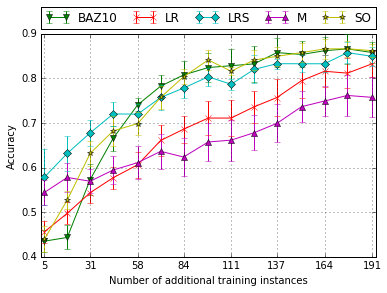

In [64]:
markers = {'LR': 'rx-', 'LRS': 'cD-', 'BA': 'bs-','BAZ10': 'gv-','SO': 'y*-', 'M': 'm^-'}
plot_additional_data_expmt(additional_data, scores, markers, xlabel='Number of additional training instances',
                           ylabel='Accuracy', tofile='../paper/figures/canadian_parliament_main_expt.pdf')

In [22]:
from sklearn.feature_selection import chi2

Xstack = sparse.vstack([X[36], X[39]])
Ystack = np.hstack([Y[36], Y[39]])
Cstack = np.hstack([C[36], C[39]])
x2, pval = chi2(Xstack, Ystack)
x2_sort_idx = np.argsort(x2)

for ft_idx in x2_sort_idx[::-1][:10]:
    vals = tuple([vec[ft_idx] for vec in [feature_names, x2, pval]])
    print("%20s\t%5.3f\t%5.3f" % vals)

            liberals	15.632	0.000
       conservatives	8.356	0.004
                2007	4.819	0.028
         afghanistan	4.512	0.034
             farmers	3.729	0.053
              senate	3.018	0.082
            property	2.999	0.083
               taxes	2.944	0.086
             deficit	2.445	0.118
                2006	2.183	0.139


### Common top features

For this experiment, we fit a logistic regression model on the data from each parliament. We then look at the N features with the largest coefficient in this model for each class (i.e. 'Liberal' and 'Conservative'). This gives us the N most predictive features for each party in every parliament.

We then compute a common features score to see how close the predictive vocabularies are for two different parties in two parliaments. Let's note $C_{ijn}$ the coefficients vector for party $i$ in parliament $j$ for the top $n$ features and $F_{ijn}$ the corresponding features vector, then we compute the common features score $S$ as follows:

$$
S(i,j,r,s,n) = \sum_{v,w,F_{ijn}[v]=F_{rsn}[w]}{C_{ijn}[v] + C_{rsn}[w]}
$$

In another words the common features score is the sum of the coefficients for the features that appear in the two parliament/party pairs we want to compare.

In [653]:
def get_top_features(clf, p, feature_names, labels, n=10):
    clf.fit(X[p],Y[p])
    top_n_idx = {}
    label2index = {}
    top_features_dict = {}
    if len(labels) == 2:
        label2index[labels[0]] = 0
        label2index[labels[1]] = 0
        sorted_idx = np.argsort(clf.coef_[0])
        top_n_idx[labels[0]] = sorted_idx[::-1][:n]
        top_n_idx[labels[1]] = sorted_idx[:n]
    else:
        for i, l in enumerate(labels):
            label2index[l] = i
            top_n_idx[l] = np.argsort(clf.coef_[i])[::-1][:n]
    for label, top_n in top_n_idx.items():
        top_features = feature_names[top_n]
        top_coef = clf.coef_[label2index[label]][top_n]
        top_features_dict[label] = list(zip(top_features, top_coef))
    return top_features_dict        
    


In [656]:
top_features = {}
for parl in parl_number:
    top_features[parl] = get_top_features(svc_clf, parl, feature_names, labels, n=100)


In [817]:
labels = le.classes_
feature_names = np.array(vec.get_feature_names())

def common_features_coef_ratio(parl1, party1, parl2, party2):
    top_dict1 = get_top_features(svc_clf, parl1, feature_names, labels, n=n)
    fts_p1, coef_p1 = zip(*top_dict1[party1])
    fts_p1 = np.array(fts_p1)
    coef_p1 = np.abs(coef_p1)

    top_dict2 = get_top_features(svc_clf, parl2, feature_names, labels, n=n)
    fts_p2, coef_p2 = zip(*top_dict2[party2])
    fts_p2 = np.array(fts_p2)
    coef_p2 = np.abs(coef_p2)
    
    common_fts_idx = [(i, int(np.where(fts_p2 == fts_p1[i])[0])) for i in range(fts_p1.shape[0]) if fts_p1[i] in fts_p2]
    acc = 0
    print("Common features between %d%s and %d%s:" % (parl1, party1[0], parl2, party2[0]))
    if not common_fts_idx:
        print("\tNone")
    else:
        header = "\t  %-20s\t%s\t%s\t%s\t%s\t%s\t%s" % ('feature name', 'idx1', 'coef1', 'idx2', 'coef2', 'dt idx', 'dt coef')
        print(header)
        print('\t\t%s' % ('-'*len(header)))
    sum_coefs = np.sum(coef_p1) + np.sum(coef_p2)
    for idx1, idx2 in common_fts_idx:
        acc += coef_p1[idx1]
        acc += coef_p2[idx2]
        print("\t- %-20s\t%d\t%.3f\t%d\t%.3f\t%d\t%.3f" % (fts_p1[idx1], idx1, coef_p1[idx1], idx2, coef_p2[idx2],
                                                     np.abs(idx1-idx2), np.abs(coef_p1[idx1]-coef_p2[idx2])))
    return acc/sum_coefs

In [818]:
n = 50
common_features_matrix = np.zeros((6,6))
for p1_idx, parl1 in enumerate(parl_number):
    for p2_idx, parl2 in enumerate(parl_number):
        for pa1_idx, party1 in enumerate(le.classes_):
            for pa2_idx, party2 in enumerate(le.classes_):
                r = p1_idx*2 + pa1_idx
                c = p2_idx*2 + pa2_idx
                if common_features_matrix[c,r] == 0 and c != r:
                    common_features_matrix[r,c] = common_features_coef_ratio(parl1, party1, parl2, party2)
# common_features_matrix /= np.sum(common_features_matrix)
axis_names = ["%d%s" % (parl, party[0]) for parl in parl_number for party in le.classes_]

Common features between 36C and 36L:
	None
Common features between 36L and 36C:
	None
Common features between 36C and 39C:
	  feature name        	idx1	coef1	idx2	coef2	dt idx	dt coef
		------------------------------------------------------------
	- ontario             	12	0.471	5	0.667	7	0.196
	- deficit             	14	0.452	24	0.433	10	0.019
	- nation              	45	0.300	26	0.422	19	0.123
Common features between 36C and 39L:
	  feature name        	idx1	coef1	idx2	coef2	dt idx	dt coef
		------------------------------------------------------------
	- report              	1	0.786	6	0.653	5	0.133
	- standing            	2	0.765	9	0.647	7	0.118
	- languages           	9	0.533	7	0.652	2	0.119
	- proud               	16	0.450	21	0.496	5	0.046
	- benefits            	25	0.364	28	0.405	3	0.040
	- bloc                	26	0.363	4	0.724	22	0.361
	- provides            	29	0.362	18	0.503	11	0.141
	- benefit             	40	0.314	20	0.497	20	0.183
	- committed           	41	0.311	2	0.784	39	0

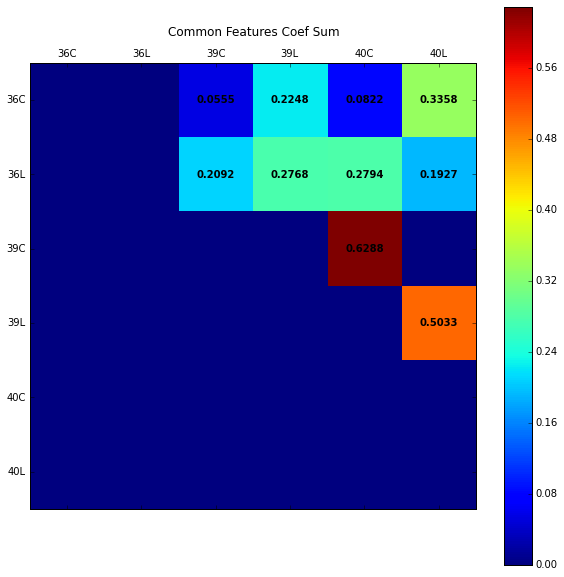

In [785]:
plot_matrix(common_features_matrix, 'Common Features Coef Sum',axis_names, axis_names, figsize=(10, 10),
            xlabel = '', ylabel = '')